In [1]:
# OceanRAIN reading, first attempt mid Nov 2017.
# revisited 19/3/18
# work on again late may / early june, producing some plots for 
#  earthcare workshop poster

# copied over and modified mid nov 2018 for paper prep
# cleaned up a bit dec 2018 before submission -- 2pan box/whisker plot is the thing used in paper
# revisited for minor plot changes 26/03/19

import h5py
import glob
import subprocess

In [2]:

# 'native' OceanRAIN data... read in output from collate_m first
typ = 'M4' #Ss3'
dir_raw_data = "/home/dudavid/projects/dsd/dj/data/"
# take every _th point to save time:
per = 1 #5

dm = np.load(dir_raw_data+'alldmd'+typ+'.npy')[::per]
rr = np.load(dir_raw_data+'allrrd'+typ+'.npy')[::per]
ku = np.load(dir_raw_data+'allkud'+typ+'.npy')[::per]
ka = np.load(dir_raw_data+'allkad'+typ+'.npy')[::per]
mu = np.load(dir_raw_data+'allmud'+typ+'.npy')[::per]
la = np.load(dir_raw_data+'alllatd'+typ+'.npy')[::per]
lo = np.load(dir_raw_data+'alllond'+typ+'.npy')[::per]
nw = np.log10( np.load(dir_raw_data+'allnwd'+typ+'.npy')[::per] ) # given as log10()
ss = np.load(dir_raw_data+'allssd'+typ+'.npy')[::per]
dt = np.load(dir_raw_data+'alldtd'+typ+'.npy')[::per]


14
18286 -60 -50
8846 -50 -40
4966 -40 -30
1125 -30 -20
2710 -20 -10
2968 -10 0
7672 0 10
7171 10 20
2163 20 30
6089 30 40
12318 40 50
8698 50 60
5052 60 70
3761 70 80
[16  8  4  1  2  3  7  6  2  5 11  8  4  3]
(14,)


(0, 15)

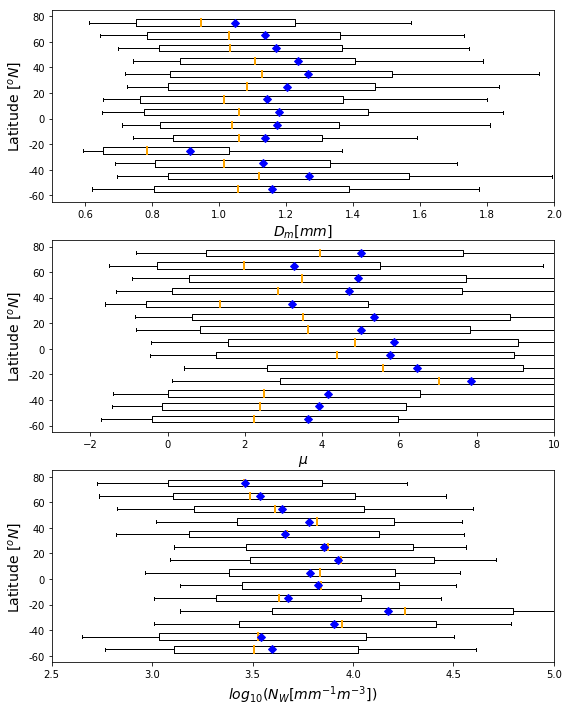

In [3]:
# create latitudinal box-and-whisker plots for Dm and mu (perhaps weighted by RR/RWC?)
bznss = 20 # degrees lat
maxlat, minlat = 80, -60
ny = int((maxlat - minlat)/bznss)
print(ny)
latz = la # np.array(laall)
zave = np.zeros(ny)
for y in range(ny):
    lasub = np.logical_and( latz >= minlat+bznss*y, latz < minlat+(bznss*(y+1)))
    print(np.size(latz[lasub]),minlat+bznss*y,minlat+bznss*(y+1))
    zave[y] = np.size(latz[lasub])
multiple = np.round(zave/float(np.min(zave))).astype(int)
print(multiple)

subr = ku >= 15 # subset of GPM-visible points only for boxplot -- only used if select_gpm = True !!
select_gpm = False

zima = 2660 #np.min(zave).astype(int)
if bznss==20: zima=5650
# if wanting equal number of points in each lat band for fair statistics:
zmu, zdm, znw = np.zeros([zima,ny])+np.nan, np.zeros([zima,ny])+np.nan, np.zeros([zima,ny])+np.nan
zrr = np.zeros([zima,ny])+np.nan

def init_list_of_objects(size):
    list_of_objects = list()
    for i in range(0,size):
        list_of_objects.append( list() ) #different object reference each time
    return list_of_objects
all_dmz = init_list_of_objects(ny)
all_muz = init_list_of_objects(ny)
all_nwz = init_list_of_objects(ny)

for y in range(ny):
    if not select_gpm:
        lasub = np.logical_and( latz >= minlat+bznss*y, latz < minlat+(bznss*(y+1)))
        all_dmz[y].append(dm[lasub])
        all_muz[y].append(mu[lasub])
        all_nwz[y].append(nw[lasub])
        lenny = len(dm[lasub])
        if lenny > zima: lenny=zima
        zdm[0:lenny,y] = np.random.choice(dm[lasub],lenny)
        zmu[0:lenny,y] = np.random.choice(mu[lasub],lenny)
        znw[0:lenny,y] = np.random.choice(nw[lasub],lenny)
    if select_gpm:
        lasub = np.logical_and( latz[subr] >= minlat+bznss*y, latz[subr] < minlat+(bznss*(y+1)))
        all_dmz[y].append(dm[subr][lasub])
        all_muz[y].append(mu[subr][lasub])
        all_nwz[y].append(nw[subr][lasub])
        lenny = len(dm[subr][lasub])
        if lenny > zima: lenny=zima
        zdm[0:lenny,y] = np.random.choice(dm[subr][lasub],lenny) #[0:lenny]
        zmu[0:lenny,y] = np.random.choice(mu[subr][lasub],lenny) #mu[subr][lasub][0:lenny]
        znw[0:lenny,y] = np.random.choice(nw[subr][lasub],lenny) #nw[subr][lasub][0:lenny]
    
mask = ~np.isnan(zdm)
fdm = [d[m] for d, m in zip(zdm.T, mask.T)]
fmu = [d[m] for d, m in zip(zmu.T, mask.T)]
fnw = [d[m] for d, m in zip(znw.T, mask.T)]
print(np.shape(fdm))
#mask = ~np.isnan(zcdm)
#fcdm = [d[m] for d, m in zip(zcdm.T, mask.T)]
#fcmu = [d[m] for d, m in zip(zcmu.T, mask.T)]
#fcnw = [d[m] for d, m in zip(zcnw.T, mask.T)]

zex = np.arange(minlat,maxlat+bznss,bznss)#+bznss/2.0
lb = [str(i) for i in zex]
ll,ul = 10, 90 # lower and upper limits for whiskers
fs = 14 # fontsize

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 12))
mlp = dict(marker='D', markeredgecolor='blue', markerfacecolor='blue')#firebrick')
dlp = dict(linewidth=2.0, color='orange') # median line style

dmz_plt = [np.array(all_dmz[x]).ravel() for x in range(ny)] # make usable by boxplot 
muz_plt = [np.array(all_muz[x]).ravel() for x in range(ny)]
nwz_plt = [np.array(all_nwz[x]).ravel() for x in range(ny)]

axes[0].boxplot(dmz_plt, sym='',vert=False, whis=[ll,ul],meanprops=mlp,showmeans=True,medianprops=dlp)
axes[1].boxplot(muz_plt, sym='',vert=False, whis=[ll,ul],meanprops=mlp,showmeans=True,medianprops=dlp)
axes[2].boxplot(nwz_plt, sym='',vert=False, whis=[ll,ul],meanprops=mlp,showmeans=True,medianprops=dlp)
axes[0].set_xlabel(r"$D_m [mm]$",fontsize=fs)
axes[1].set_xlabel(r"$\mu$",fontsize=fs)
axes[2].set_xlabel(r"$log_{10} (N_W [mm^{-1} m^{-3}])$",fontsize=fs)
axes[0].set_ylabel(r'Latitude $[^o N]$',fontsize=fs)
axes[1].set_ylabel(r'Latitude $[^o N]$',fontsize=fs)
axes[2].set_ylabel(r'Latitude $[^o N]$',fontsize=fs)
axes[0].set_yticks(np.arange(ny/2+1)*2+.5)
axes[1].set_yticks(np.arange(ny/2+1)*2+.5)
axes[2].set_yticks(np.arange(ny/2+1)*2+.5)
axes[0].set_yticklabels(lb[::2])
axes[1].set_yticklabels(lb[::2])
axes[2].set_yticklabels(lb[::2])
#axes[2].set_xscale('log')
axes[0].set_xlim([0.5,2.0])
axes[1].set_xlim([-3,10])
axes[2].set_xlim([2.5,5])
#axes[2].set_xlim([2e2,1e5])
axes[0].set_ylim([0,ny+1])
axes[1].set_ylim([0,ny+1])
axes[2].set_ylim([0,ny+1])

In [4]:

finam = 'img/whiskers_v7'
if select_gpm: finam+='_gpm'
plt.savefig(finam+'.png',bbox_inches="tight",transparent=True,dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

(0, 11)

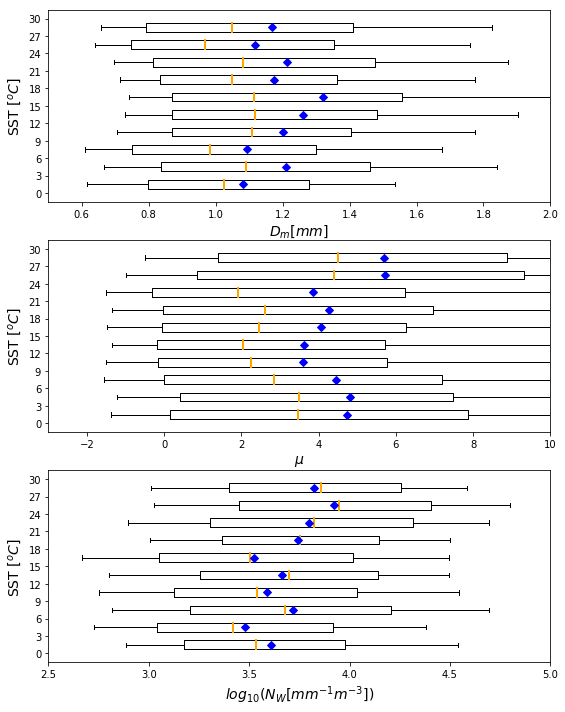

In [5]:
#  try doing the same for moisure and then SST

subr = ku >= 15 # subset of rain rates for boxplot
#subr = rr > 0.2 # subset of rain rates for boxplot
select_gpm = False


# can pick e.g. dewpoint (dt) or sst (ss)  [could add more later]
#  -- there are some missing (-99.9) values in there, but it's okay for this purpose
#var_choice = 'TD' 
var_choice = 'SST' 
if var_choice[0]=='T':
    varr = dt 
    labls = 'T_D [$^o C]$'
    maxthng, minthng = 25, 0
elif var_choice[0]=='S': 
    varr = ss  
    labls = 'SST [$^o C$]'
    maxthng, minthng = 30, 0
bznss = 5 # interval, should be fine for both
nys = int((maxthng - minthng)/bznss)

def init_list_of_objects(size):
    list_of_objects = list()
    for i in range(0,size):
        list_of_objects.append( list() ) #different object reference each time
    return list_of_objects
all_dmzs = init_list_of_objects(nys)
all_muzs = init_list_of_objects(nys)
all_nwzs = init_list_of_objects(nys)

for y in range(nys):
    if not select_gpm:
        lasub = np.logical_and( varr >= minthng+bznss*y, varr < minthng+(bznss*(y+1)))
        all_dmzs[y].append(dm[lasub])
        all_muzs[y].append(mu[lasub])
        all_nwzs[y].append(nw[lasub])
    if select_gpm:
        lasub = np.logical_and( varr[subr] >= minthng+bznss*y, varr[subr] < minthng+(bznss*(y+1)))
        all_dmzs[y].append(dm[subr][lasub])
        all_muzs[y].append(mu[subr][lasub])
        all_nwzs[y].append(nw[subr][lasub])

zex = np.arange(minthng,maxthng+bznss,bznss)#+bznss/2.0
lbs = [str(i) for i in zex]
ll,ul = 10, 90 # lower and upper limits for whiskers
fs = 14 # fontsize

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 12))
#mlp = dict(linewidth=2.0, color='blue')  # mean line/point style
mlp = dict(marker='D', markeredgecolor='blue', markerfacecolor='blue')#firebrick')
dlp = dict(linewidth=2.0, color='orange') # median line style

dmz_plts = [np.array(all_dmzs[x]).ravel() for x in range(nys)] # make usable by boxplot 
muz_plts = [np.array(all_muzs[x]).ravel() for x in range(nys)]
nwz_plts = [np.array(all_nwzs[x]).ravel() for x in range(nys)]

axes[0].boxplot(dmz_plts, sym='',vert=False, whis=[ll,ul],meanprops=mlp,showmeans=True,medianprops=dlp)
axes[1].boxplot(muz_plts, sym='',vert=False, whis=[ll,ul],meanprops=mlp,showmeans=True,medianprops=dlp)
axes[2].boxplot(nwz_plts, sym='',vert=False, whis=[ll,ul],meanprops=mlp,showmeans=True,medianprops=dlp)
axes[0].set_xlabel(r"$D_m [mm]$",fontsize=fs)
axes[1].set_xlabel(r"$\mu$",fontsize=fs)
axes[2].set_xlabel(r"$log_{10} (N_W [mm^{-1} m^{-3}])$",fontsize=fs)
axes[0].set_ylabel(labls,fontsize=fs)
axes[1].set_ylabel(labls,fontsize=fs)
axes[2].set_ylabel(labls,fontsize=fs)
yby = 1
axes[0].set_yticks(np.arange(nys/yby+1)*yby+.5)
axes[1].set_yticks(np.arange(nys/yby+1)*yby+.5)
axes[2].set_yticks(np.arange(nys/yby+1)*yby+.5)
axes[0].set_yticklabels(lbs[::yby])
axes[1].set_yticklabels(lbs[::yby])
axes[2].set_yticklabels(lbs[::yby])
axes[0].set_xlim([0.5,2.0])
axes[1].set_xlim([-3,10])
axes[2].set_xlim([2.5,5])
axes[0].set_ylim([0,nys+1])
axes[1].set_ylim([0,nys+1])
axes[2].set_ylim([0,nys+1])

In [6]:

finam = 'img/whiskers_'+var_choice+'_v7'
if select_gpm: finam+='.gpm'
plt.savefig(finam+'.png',bbox_inches="tight",transparent=True,dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

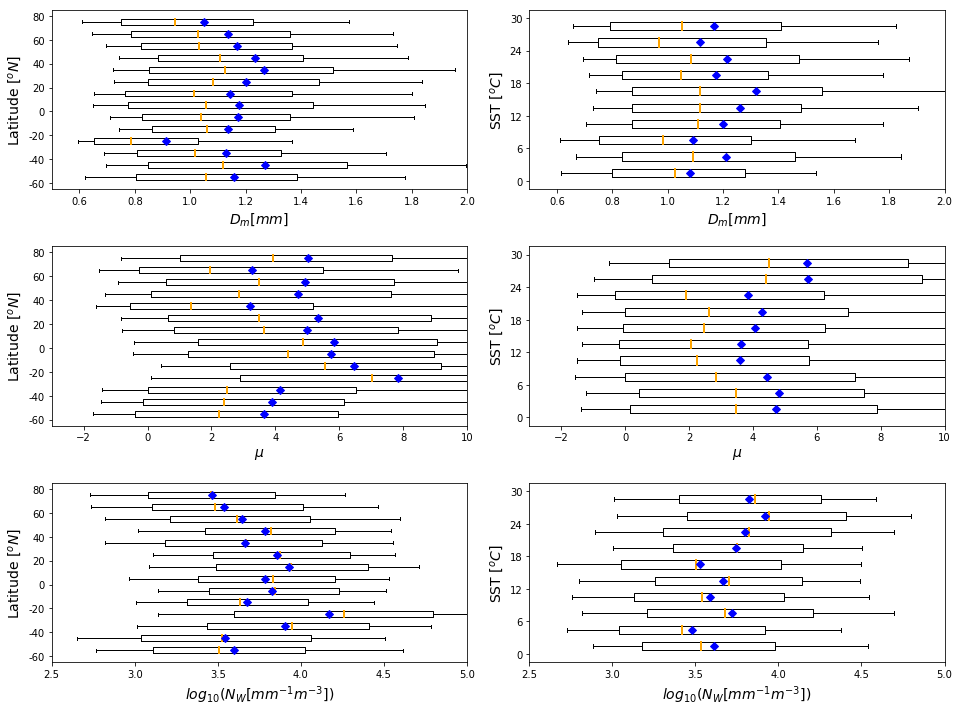

In [7]:
# putting plotting code together to make a doublewide plot figure:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))

mlp = dict(marker='D', markeredgecolor='blue', markerfacecolor='blue')#firebrick')
dlp = dict(linewidth=2.0, color='orange') # median line style

# all plotting arrays should've been set above

axes[0,0].boxplot(dmz_plt, sym='',vert=False, whis=[ll,ul],meanprops=mlp,showmeans=True,medianprops=dlp)
axes[1,0].boxplot(muz_plt, sym='',vert=False, whis=[ll,ul],meanprops=mlp,showmeans=True,medianprops=dlp)
axes[2,0].boxplot(nwz_plt, sym='',vert=False, whis=[ll,ul],meanprops=mlp,showmeans=True,medianprops=dlp)
axes[0,0].set_xlabel(r"$D_m [mm]$",fontsize=fs)
axes[1,0].set_xlabel(r"$\mu$",fontsize=fs)
axes[2,0].set_xlabel(r"$log_{10} (N_W [mm^{-1} m^{-3}])$",fontsize=fs)
axes[0,0].set_ylabel(r'Latitude $[^o N]$',fontsize=fs)
axes[1,0].set_ylabel(r'Latitude $[^o N]$',fontsize=fs)
axes[2,0].set_ylabel(r'Latitude $[^o N]$',fontsize=fs)
axes[0,0].set_yticks(np.arange(ny/2+1)*2+.5)
axes[1,0].set_yticks(np.arange(ny/2+1)*2+.5)
axes[2,0].set_yticks(np.arange(ny/2+1)*2+.5)
axes[0,0].set_yticklabels(lb[::2])
axes[1,0].set_yticklabels(lb[::2])
axes[2,0].set_yticklabels(lb[::2])
axes[0,0].set_xlim([0.5,2.0])
axes[1,0].set_xlim([-3,10])
axes[2,0].set_xlim([2.5,5])
axes[0,0].set_ylim([0,ny+1])
axes[1,0].set_ylim([0,ny+1])
axes[2,0].set_ylim([0,ny+1])
axes[0,1].boxplot(dmz_plts, sym='',vert=False, whis=[ll,ul],meanprops=mlp,showmeans=True,medianprops=dlp)
axes[1,1].boxplot(muz_plts, sym='',vert=False, whis=[ll,ul],meanprops=mlp,showmeans=True,medianprops=dlp)
axes[2,1].boxplot(nwz_plts, sym='',vert=False, whis=[ll,ul],meanprops=mlp,showmeans=True,medianprops=dlp)
axes[0,1].set_xlabel(r"$D_m [mm]$",fontsize=fs)
axes[1,1].set_xlabel(r"$\mu$",fontsize=fs)
axes[2,1].set_xlabel(r"$log_{10} (N_W [mm^{-1} m^{-3}])$",fontsize=fs)
axes[0,1].set_ylabel(labls,fontsize=fs)
axes[1,1].set_ylabel(labls,fontsize=fs)
axes[2,1].set_ylabel(labls,fontsize=fs)
axes[0,1].set_yticks(np.arange(nys/2+1)*2+.5)
axes[1,1].set_yticks(np.arange(nys/2+1)*2+.5)
axes[2,1].set_yticks(np.arange(nys/2+1)*2+.5)
axes[0,1].set_yticklabels(lbs[::2])
axes[1,1].set_yticklabels(lbs[::2])
axes[2,1].set_yticklabels(lbs[::2])
axes[0,1].set_xlim([0.5,2.0])
axes[1,1].set_xlim([-3,10])
axes[2,1].set_xlim([2.5,5])
axes[0,1].set_ylim([0,nys+1])
axes[1,1].set_ylim([0,nys+1])
axes[2,1].set_ylim([0,nys+1])

finam = 'img/whiskers_2pan_v1-1'
plt.subplots_adjust(wspace=.15,hspace=0.32)
plt.savefig(finam+'.png',bbox_inches="tight",transparent=True,dpi=300)
plt.show()

In [8]:
dontrunthnx
## trying to calculate mass spectrum and related parameters following
##   williams et al. 2014
#cts = np.load(dir_raw_data+'rallcts'+typ+'.80.npy')[::per]  # N(D) in mm-1 m-3
#m = np.empty_like(cts) 
#print(np.shape(m))
#nx = 70  # number of size bins to use (out of 80 max, given above in filename)
#ex = np.load('/home/dudavid/projects/dsd/oceanrain_binsizes.npy')[12:(12+nx+1)] #  in mm
#dD = [ex[n+1]-ex[n] for n in range(len(ex)-1)]
##print(ex)
#m = [(np.pi/(6e3)) * 1.0 * cts[x,:] * ex[x]**3 for x in range(nx)]  #[g mm-1 m-3] (williams et al. eq 13)
## can calculate sigma_m from either N(D) or m(D)  (williams et al eq 15)
#sigma_m = [(( np.sum( [(ex[x]-dm[xx])**2 * cts[x,xx] * ex[x]**3 *dD[x] for x in range(nx)])) / \
#            ( np.sum( [                    cts[x,xx] * ex[x]**3 *dD[x] for x in range(nx)])) )**0.5 \
#           for xx in range(np.shape(cts)[1])]
##sigma_mm= [(( np.sum( [(ex[x]-dm[xx])**2 * m[x,xx] *dD[x] for x in range(nx)])) / \
##            ( np.sum( [                    m[x,xx] *dD[x] for x in range(nx)])) )**0.5 \
##           for xx in range(np.shape(cts)[1])]
#print(np.shape(sigma_m))
#print(info(sigma_m))
##print(info(sigma_mm))

NameError: name 'dontrunthnx' is not defined

In [ ]:
#import scipy.stats
#for bm in np.arange(1.39,1.40,.001):
#    sigma_m_prime = sigma_m / dm**bm
#    print(scipy.stats.pearsonr(sigma_m_prime, dm))
#bm = 1.392
#sigma_m_prime = sigma_m / dm**bm
#print(scipy.stats.pearsonr(sigma_m_prime, dm))
#print(info(sigma_m_prime))

#scipy.stats.pearsonr(v1,v2)

In [ ]:
#sigma_m = np.array(sigma_m)
#sigma_m_prime = np.array(sigma_m_prime)

In [ ]:
# create latitudinal box-and-whisker plots for Dm and sigma params (NEW 28/11)


def init_list_of_objects(size):
    list_of_objects = list()
    for i in range(0,size):
        list_of_objects.append( list() ) #different object reference each time
    return list_of_objects
all_dmz   = init_list_of_objects(ny)
all_sigz, all_sigpz, all_sigzs, all_sigpzs = \
 init_list_of_objects(ny),init_list_of_objects(ny),init_list_of_objects(ny),init_list_of_objects(ny)

bznss = 20 # interval, should be fine for both
select_gpm=False
for y in range(ny):
    lasub = np.logical_and( latz >= minlat+bznss*y, latz < minlat+(bznss*(y+1)))
    #all_dmz[y].append(dm[lasub])
    all_sigz[y].append(sigma_m[lasub])
    all_sigpz[y].append(sigma_m_prime[lasub])
zex = np.arange(minlat,maxlat+bznss,bznss)
lb = [str(i) for i in zex]

var_choice = 'SST' 
varr = ss  
labl = '$SST [^o C$]'
maxthng, minthng = 30, 0
bznss = 5 # interval, should be fine for both
ny2 = int((maxthng - minthng)/bznss)
for y in range(ny2):
    lasub = np.logical_and(varr >= minthng+bznss*y, varr < minthng+(bznss*(y+1)))
    all_sigzs[y].append(sigma_m[lasub])
    all_sigpzs[y].append(sigma_m_prime[lasub])
    
zex2 = np.arange(minthng,maxthng+bznss,bznss)
lb2 = [str(i) for i in zex2]
ll,ul = 10, 90 # lower and upper limits for whiskers
fs = 14 # fontsize

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 12))
#mlp = dict(linewidth=2.0, color='blue')  # mean line/point style
mlp = dict(marker='D', markeredgecolor='black', markerfacecolor='blue')#firebrick')
dlp = dict(linewidth=2.0, color='orange') # median line style

#dmz_plt = [np.array(all_dmz[x]).ravel() for x in range(ny)] # make usable by boxplot 
sigz_plt = [np.array(all_sigz[x]).ravel() for x in range(ny)]
sigpz_plt = [np.array(all_sigpz[x]).ravel() for x in range(ny)]
sigzs_plt = [np.array(all_sigzs[x]).ravel() for x in range(ny2)]
sigpzs_plt = [np.array(all_sigpzs[x]).ravel() for x in range(ny2)]

axes[0].boxplot(sigpz_plt, sym='',vert=False, whis=[ll,ul],meanprops=mlp,showmeans=True,medianprops=dlp)
axes[1].boxplot(sigpzs_plt, sym='',vert=False, whis=[ll,ul],meanprops=mlp,showmeans=True,medianprops=dlp)
axes[0].set_xlabel(r"$\sigma_m'$",fontsize=fs)
axes[1].set_xlabel(r"$\sigma_m'$",fontsize=fs)
axes[0].set_ylabel(r'Latitude $[^o N]$',fontsize=fs)
axes[1].set_ylabel(labl,fontsize=fs)
axes[0].set_yticks(np.arange(ny/2+1)*2+.5)
axes[1].set_yticks(np.arange(ny2/2+1)*2+.5)
axes[0].set_yticklabels(lb[::2])
axes[1].set_yticklabels(lb2[::2])
axes[0].set_xlim([.1,.8])
axes[1].set_xlim([.1,.8])
axes[0].set_ylim([0,ny+1])
axes[1].set_ylim([0,ny2+1])

In [ ]:

finam = 'img/whiskers_sigmas_v6'
if select_gpm: finam+='.gpm'
plt.savefig(finam+'.png',bbox_inches="tight",transparent=True,dpi=300)
plt.show()